In [4]:
# Installs all the necessary packages for the project
# %pip install pandas pandas-ta numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt
# %pip install --upgrade certifi

In [5]:
# Imports all the necessary packages for the project and fixes ssl error
import ssl
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# Get SP500 data    
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['Date', 'Symbol']

df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-02-03 A        36.894344   40.164520   41.831188   40.114449   41.595135   
           AAL      32.015495   33.959999   34.480000   33.049999   33.950001   
           AAPL     15.703110   17.911785   18.133215   17.832144   17.950357   
           ABBV     31.383671   47.349998   49.490002   47.060001   49.400002   
           ABT      29.580902   35.849998   36.950001   35.799999   36.580002   
...                       ...         ...         ...         ...         ...   
2024-01-31 YUM     129.490005  129.490005  131.979996  129.259995  131.449997   
           ZBH     125.599998  125.599998  127.449997  124.019997  124.019997   
           ZBRA    239.550003  239.550003  250.000000  238.479996  250.000000   
           ZION     41.900002   41.900002   43.540001   41.689999   42.189999   
           ZTS     187.809998  187.809998  192.779999  187.440002  192.130005   

                        Volume  
Date       Symbol               
2014-02-03 A         4095161.0  
           AAL      21739500.0  
           AAPL    401464000.0  
           ABBV     10314600.0  
           ABT      12231900.0  
...                        ...  
2024-01-31 YUM       2154200.0  
           ZBH       2460100.0  
           ZBRA       482600.0  
           ZION      4657400.0  
           ZTS       2150000.0  

[1235446 rows x 6 columns]

In [7]:
# Calculate features and technical indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume,
# All but RSI are normalized by subtracting the mean and dividing by the standard deviation

df['Garman-Klass'] = ((np.log(df['High'])-np.log(df['Low']))**2)/2-(2*np.log(2)-1)*((np.log(df['Adj Close'])-np.log(df['Open']))**2)  

df['RSI'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.rsi(close=x, length=20))

df['BB-Low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['BB-Mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['BB-High'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(data):
    atr = ta.atr(high=data['High'],
                        low=data['Low'],
                        close=data['Close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['ATR'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['MACD'] = df.groupby(level=1, group_keys=False)['Adj Close'].apply(compute_macd)

df['Dollar Volume'] = (df['Adj Close']*df['Volume'])/1e6

df


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-02-03 A        36.894344   40.164520   41.831188   40.114449   41.595135   
           AAL      32.015495   33.959999   34.480000   33.049999   33.950001   
           AAPL     15.703110   17.911785   18.133215   17.832144   17.950357   
           ABBV     31.383671   47.349998   49.490002   47.060001   49.400002   
           ABT      29.580902   35.849998   36.950001   35.799999   36.580002   
...                       ...         ...         ...         ...         ...   
2024-01-31 YUM     129.490005  129.490005  131.979996  129.259995  131.449997   
           ZBH     125.599998  125.599998  127.449997  124.019997  124.019997   
           ZBRA    239.550003  239.550003  250.000000  238.479996  250.000000   
           ZION     41.900002   41.900002   43.540001   41.689999   42.189999   
           ZTS     187.809998  187.809998  192.779999  187.440002  192.130005   

                        Volume  Garman-Klass        RSI    BB-Low    BB-Mid  \
Date       Symbol                                                             
2014-02-03 A         4095161.0     -0.004678        NaN       NaN       NaN   
           AAL      21739500.0     -0.000433        NaN       NaN       NaN   
           AAPL    401464000.0     -0.006770        NaN       NaN       NaN   
           ABBV     10314600.0     -0.078236        NaN       NaN       NaN   
           ABT      12231900.0     -0.016923        NaN       NaN       NaN   
...                        ...           ...        ...       ...       ...   
2024-01-31 YUM       2154200.0      0.000130  51.308297  4.856335  4.872943   
           ZBH       2460100.0      0.000310  65.258890  4.792366  4.813736   
           ZBRA       482600.0      0.000408  43.835933  5.488361  5.532482   
           ZION      4657400.0      0.000924  50.223482  3.724677  3.784528   
           ZTS       2150000.0      0.000195  47.862792  5.227139  5.263276   

                    BB-High       ATR      MACD  Dollar Volume  
Date       Symbol                                               
2014-02-03 A            NaN       NaN       NaN     151.088280  
           AAL          NaN       NaN       NaN     696.000860  
           AAPL         NaN       NaN       NaN    6304.233249  
           ABBV         NaN       NaN       NaN     323.710011  
           ABT          NaN       NaN       NaN     361.830636  
...                     ...       ...       ...            ...  
2024-01-31 YUM     4.889551  0.283156  0.160187     278.947370  
           ZBH     4.835105 -0.368786  0.490990     308.988556  
           ZBRA    5.576602  0.310182 -0.183966     115.606831  
           ZION    3.844379  0.680608  0.558559     195.145067  
           ZTS     5.299413  0.937982 -0.347186     403.791495  

[1235446 rows x 14 columns]

In [8]:
# Aggregate to monthly data and filter top 150 most liquid stocks for each month

tech_cols = [c for c in df.columns.unique(0) if c not in ['Dollar Volume', 'Volume', 'Open',
                                                          'High', 'Low', 'Close']]

tech_data = (pd.concat([df.unstack('Symbol')['Dollar Volume'].resample('M').mean().stack('Symbol').to_frame('Dollar Volume'),
                   df.unstack()[tech_cols].resample('M').last().stack('Symbol')],
                  axis=1)).dropna()

# Calculate 5-year rolling average of Dollar Volume
tech_data['Dollar Volume'] = (tech_data.loc[:, 'Dollar Volume'].unstack('Symbol').rolling(5*12, min_periods=12).mean().stack())

tech_data['DV Rank'] = (tech_data.groupby('Date')['Dollar Volume'].rank(ascending=False))

# Filter top 150 most liquid stocks for each month and put in new dataframe
#tech_data = tech_data[tech_data['DV Rank']<150].drop(['Dollar Volume', 'DV Rank'], axis=1)
top_150 = tech_data[tech_data['DV Rank'] < 150]

top_150


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2015-02-28 AAL        489.261943   45.477364     -0.001642  45.417050   
           AAPL      5126.441692   28.860924     -0.005285  62.555817   
           ABBV       371.581296   41.377697     -0.055845  48.492206   
           ABT        195.715545   39.949791     -0.011462  61.637770   
           ACN        189.507281   77.266312     -0.009006  55.963649   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       393.307105  433.380005      0.000374  61.349727   
           VZ         790.283224   42.349998      0.000371  68.254013   
           WFC        992.198904   50.180000      0.000214  60.466339   
           WMT        976.579011  165.250000      0.000040  62.085036   
           XOM       1415.301770  102.809998      0.000073  53.953128   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  
Date       Symbol                                                             
2015-02-28 AAL     3.807215  3.858552  3.909889  1.976591 -0.191813     35.0  
           AAPL    3.289049  3.368804  3.448558 -0.779909  0.275904      1.0  
           ABBV    3.660831  3.721655  3.782480 -0.701749 -0.423896     51.0  
           ABT     3.641809  3.685499  3.729188 -0.909134  0.367530    116.0  
           ACN     4.306899  4.345959  4.385019 -0.967321 -0.043469    120.0  
...                     ...       ...       ...       ...       ...      ...  
2024-01-31 VRTX    6.023270  6.065050  6.106831  1.560860  2.505106    116.0  
           VZ      3.639249  3.715109  3.790970  0.236071  2.853466     45.0  
           WFC     3.859580  3.911409  3.963238 -0.310662  0.880819     33.0  
           WMT     5.061397  5.091259  5.121120  0.222635  1.286321     34.0  
           XOM     4.566939  4.617149  4.667359  0.329222  0.268279     17.0  

[16092 rows x 10 columns]

In [9]:
# Calculate monthly returns for different time horizons on the top 150 most liquid stocks
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'{lag}m Return'] = (df['Adj Close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

returns = top_150.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
returns

Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985129   39.288376     -0.000319  54.607062   
           AAPL      5210.567816   22.125885     -0.003013  46.730955   
           ABBV       404.930422   38.690903     -0.051766  48.010295   
           ABT        216.240057   33.398449     -0.009964  46.271598   
           ACN        209.341644   87.900635     -0.006994  49.785670   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       393.307105  433.380005      0.000374  61.349727   
           VZ         790.283224   42.349998      0.000371  68.254013   
           WFC        992.198904   50.180000      0.000214  60.466339   
           WMT        976.579011  165.250000      0.000040  62.085036   
           XOM       1415.301770  102.809998      0.000073  53.953128   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638646  3.729458  0.677257  0.539056     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.831910 -0.352449      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.334362 -0.285914     49.0   
           ABT     3.479070  3.522661  3.566251 -0.588030 -0.392218    113.0   
           ACN     4.405534  4.474354  4.543174 -0.607231 -0.298615    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-01-31 VRTX    6.023270  6.065050  6.106831  1.560860  2.505106    116.0   
           VZ      3.639249  3.715109  3.790970  0.236071  2.853466     45.0   
           WFC     3.859580  3.911409  3.963238 -0.310662  0.880819     33.0   
           WMT     5.061397  5.091259  5.121120  0.222635  1.286321     34.0   
           XOM     4.566939  4.617149  4.667359  0.329222  0.268279     17.0   

                   1m Return  2m Return  3m Return  6m Return  9m Return  \
Date       Symbol                                                          
2016-02-29 AAL      0.054421  -0.014726  -0.001198   0.009277  -0.002847   
           AAPL    -0.001288  -0.038976  -0.063339  -0.023726  -0.031060   
           ABBV    -0.005282  -0.034844  -0.017302  -0.018800  -0.018854   
           ABT      0.023514  -0.068304  -0.046141  -0.023736  -0.023047   
           ACN     -0.050029  -0.020497  -0.022124   0.012121   0.005983   
...                      ...        ...        ...        ...        ...   
2024-01-31 VRTX     0.065104   0.105189   0.061719   0.035105   0.027085   
           VZ       0.123995   0.059958   0.064484   0.043434   0.015944   
           WFC      0.019504   0.060832   0.083785   0.016835   0.029020   
           WMT      0.048208   0.032156   0.004980   0.006759   0.011333   
           XOM      0.028306   0.000341  -0.006657  -0.004145  -0.012672   

                   12m Return  
Date       Symbol              
2016-02-29 AAL      -0.012116  
           AAPL     -0.021902  
           ABBV     -0.005579  
           ABT      -0.014815  
           ACN       0.010804  
...                       ...  
2024-01-31 VRTX      0.024773  
           VZ        0.007578  
           WFC       0.008289  
           WMT       0.012890  
           XOM      -0.007242  

[13801 rows x 16 columns]

In [10]:
# Use Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data.index.name = 'Date'
factor_data = factor_data.resample('M').last().div(100)
factor_data = factor_data.join(returns['1m Return']).sort_index()


# Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('Symbol').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  1m Return
Date       Symbol                                                   
2016-02-29 AAL    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.054421
           AAPL   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.001288
           ABBV   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.005282
           ABT    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.023514
           ACN    -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.050029
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.016350
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[13626 rows x 6 columns]

In [11]:
# Calculate Rolling Factor Betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['1m Return'], 
                                     exog=sm.add_constant(x.drop('1m Return', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

#betas 

# Join betas to returns dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (returns.join(betas.groupby('Symbol').shift()))
data.loc[:, factors] = data.groupby('Symbol', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
#data = data.drop(['Adj Close', 'Dollar Volume', 'DV Rank', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13544 entries, (Timestamp('2016-02-29 00:00:00'), 'AAL') to (Timestamp('2024-01-31 00:00:00'), 'XOM')
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar Volume  13544 non-null  float64
 1   Adj Close      13544 non-null  float64
 2   Garman-Klass   13544 non-null  float64
 3   RSI            13544 non-null  float64
 4   BB-Low         13544 non-null  float64
 5   BB-Mid         13544 non-null  float64
 6   BB-High        13544 non-null  float64
 7   ATR            13544 non-null  float64
 8   MACD           13544 non-null  float64
 9   DV Rank        13544 non-null  float64
 10  1m Return      13544 non-null  float64
 11  2m Return      13544 non-null  float64
 12  3m Return      13544 non-null  float64
 13  6m Return      13544 non-null  float64
 14  9m Return      13544 non-null  float64
 15  12m Return     13544 non-null  float64
 16  Mkt-RF         135

In [46]:
# K-Means Clustering for each month
from sklearn.cluster import KMeans
# N Clusters = 4
# Define initial centroids

target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 22))
initial_centroids[:, 6] = target_rsi_values


def get_clusters(df):
    df['Cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

data


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985129   39.288376     -0.000319  54.607062   
           AAPL      5210.567816   22.125885     -0.003013  46.730955   
           ABBV       404.930422   38.690903     -0.051766  48.010295   
           ABT        216.240057   33.398449     -0.009964  46.271598   
           ACN        209.341644   87.900635     -0.006994  49.785670   
...                          ...         ...           ...        ...   
2024-01-31 VRTX       393.307105  433.380005      0.000374  61.349727   
           VZ         790.283224   42.349998      0.000371  68.254013   
           WFC        992.198904   50.180000      0.000214  60.466339   
           WMT        976.579011  165.250000      0.000040  62.085036   
           XOM       1415.301770  102.809998      0.000073  53.953128   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638646  3.729458  0.677257  0.539056     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.831910 -0.352449      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.334362 -0.285914     49.0   
           ABT     3.479070  3.522661  3.566251 -0.588030 -0.392218    113.0   
           ACN     4.405534  4.474354  4.543174 -0.607231 -0.298615    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-01-31 VRTX    6.023270  6.065050  6.106831  1.560860  2.505106    116.0   
           VZ      3.639249  3.715109  3.790970  0.236071  2.853466     45.0   
           WFC     3.859580  3.911409  3.963238 -0.310662  0.880819     33.0   
           WMT     5.061397  5.091259  5.121120  0.222635  1.286321     34.0   
           XOM     4.566939  4.617149  4.667359  0.329222  0.268279     17.0   

                   ...  3m Return  6m Return  9m Return  12m Return    Mkt-RF  \
Date       Symbol  ...                                                          
2016-02-29 AAL     ...  -0.001198   0.009277  -0.002847   -0.012116  1.339099   
           AAPL    ...  -0.063339  -0.023726  -0.031060   -0.021902  1.063708   
           ABBV    ...  -0.017302  -0.018800  -0.018854   -0.005579  0.760874   
           ABT     ...  -0.046141  -0.023736  -0.023047   -0.014815  0.928610   
           ACN     ...  -0.022124   0.012121   0.005983    0.010804  1.149451   
...                ...        ...        ...        ...         ...       ...   
2024-01-31 VRTX    ...   0.061719   0.035105   0.027085    0.024773  0.835013   
           VZ      ...   0.064484   0.043434   0.015944    0.007578  0.613449   
           WFC     ...   0.083785   0.016835   0.029020    0.008289  1.216318   
           WMT     ...   0.004980   0.006759   0.011333    0.012890  0.785562   
           XOM     ...  -0.006657  -0.004145  -0.012672   -0.007242  1.132007   

                        SMB       HML       RMW       CMA  Cluster  
Date       Symbol                                                   
2016-02-29 AAL     1.049872  0.686796  0.757897  0.245126        0  
           AAPL   -0.186245 -0.510883  0.574295 -0.430717        1  
           ABBV    0.218663  0.084083 -0.202318 -0.081591        0  
           ABT    -0.192195 -0.536443  0.087832  0.753510        0  
           ACN    -0.148264 -0.260781  0.185544 -0.016427        0  
...                     ...       ...       ...       ...      ...  
2024-01-31 VRTX    0.048170 -1.325369 -0.075959  0.966135        0  
           VZ     -0.370609 -0.041652  0.356533  0.951550        0  
           WFC    -0.138285  1.272990 -0.671422 -0.202708        0  
           WMT    -0.504788 -0.213126  0.601755  0.643417        0  
           XOM     0.270196  0.352066 -0.437976  0.901881        0  

[13544 rows x 22 columns]

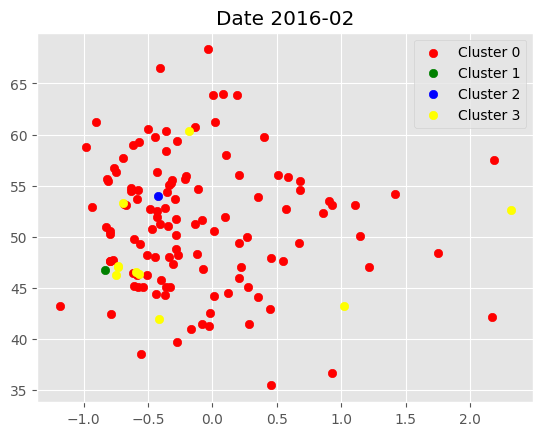

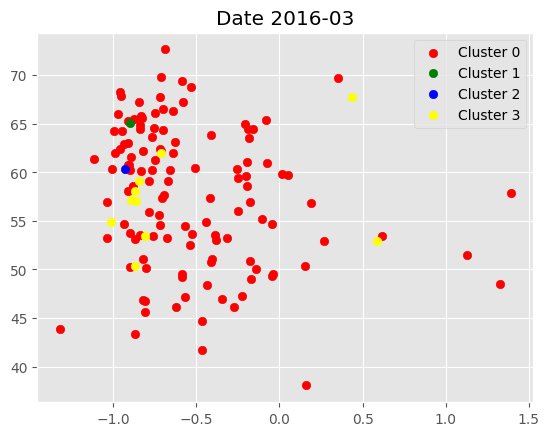

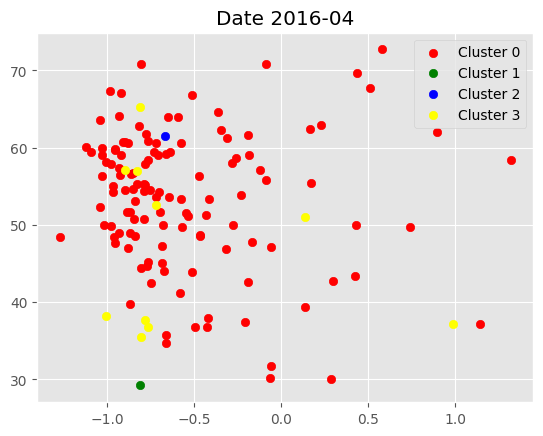

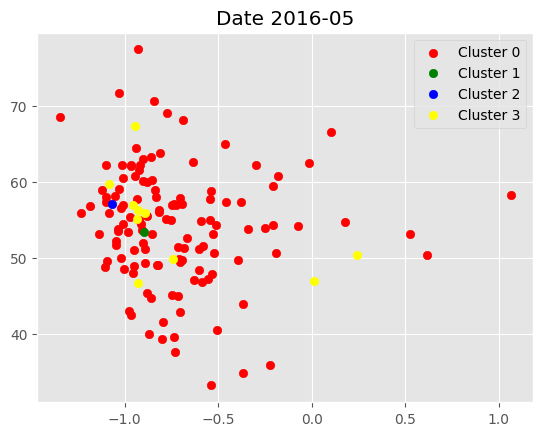

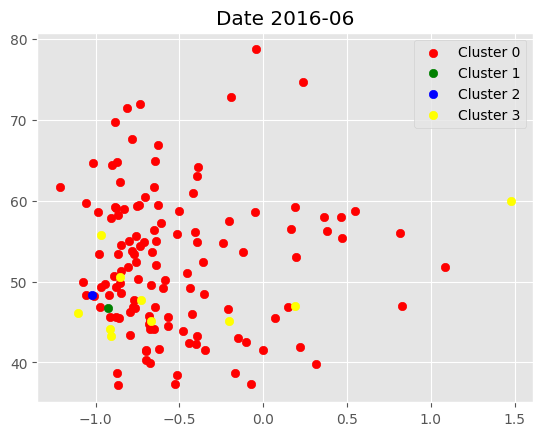

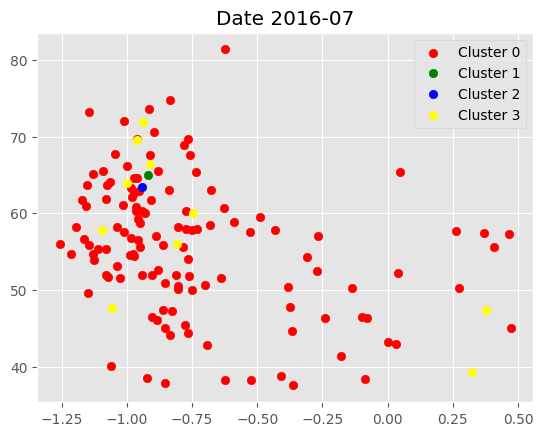

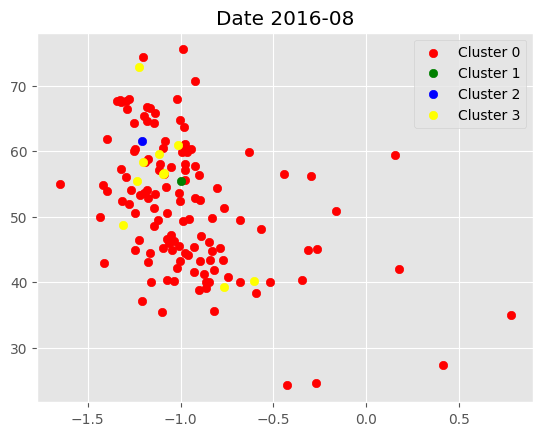

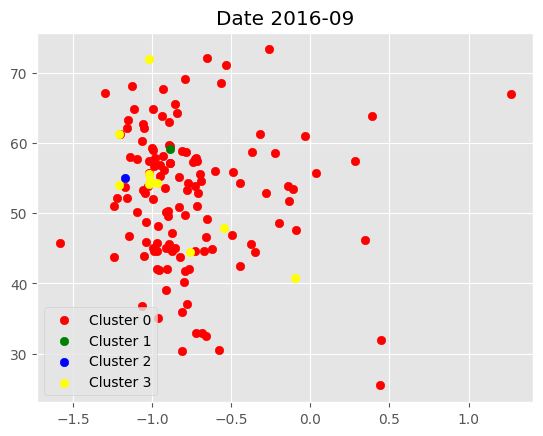

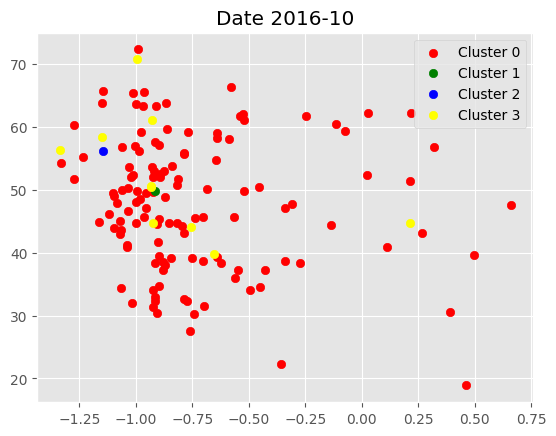

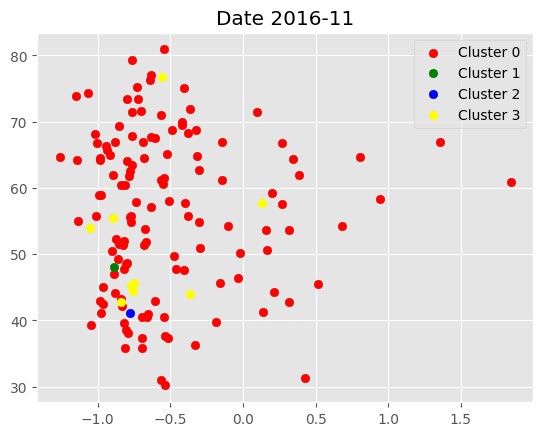

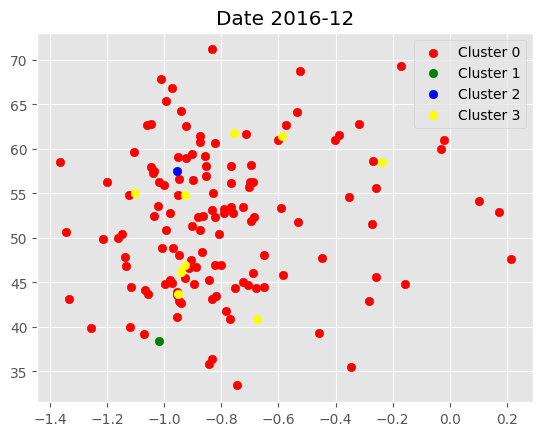

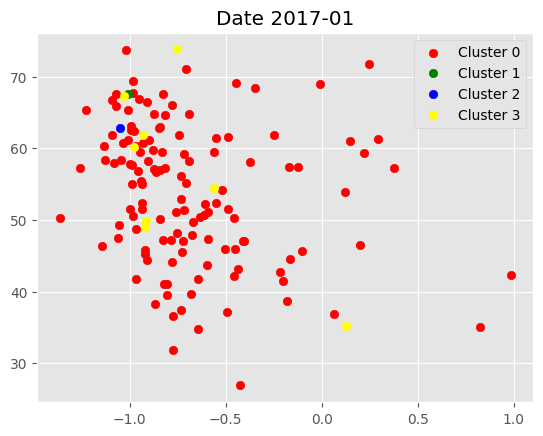

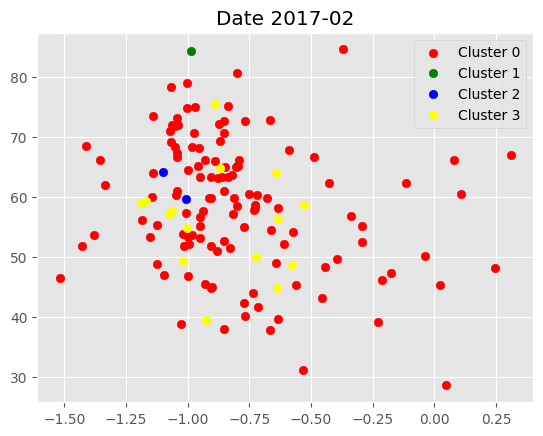

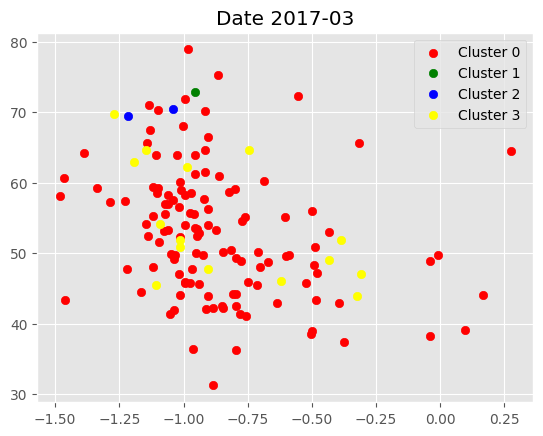

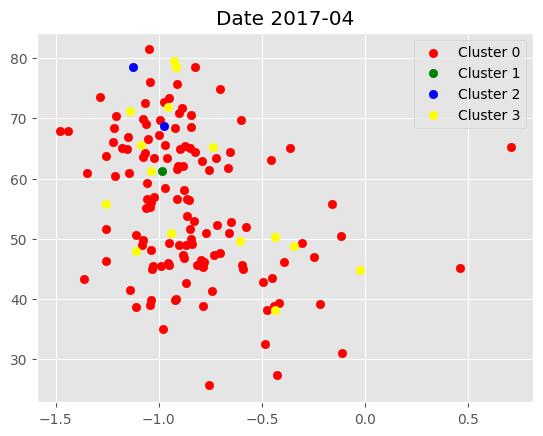

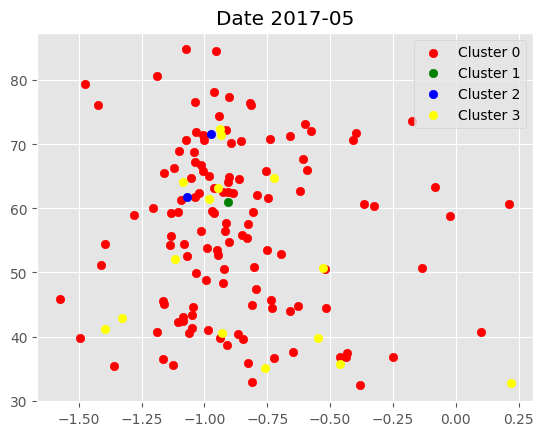

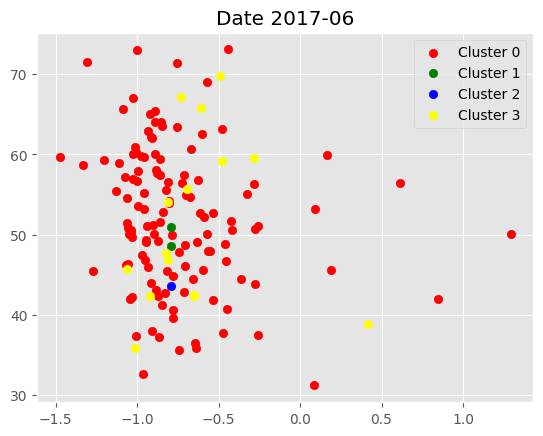

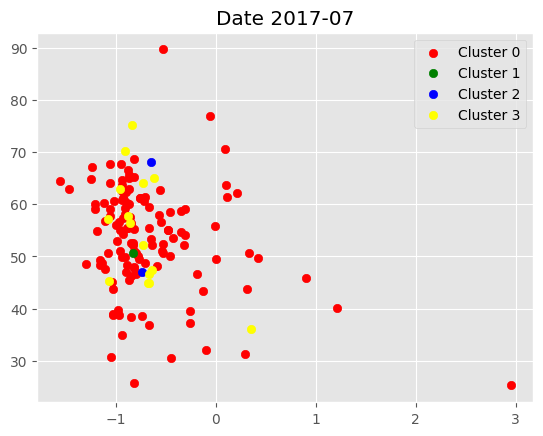

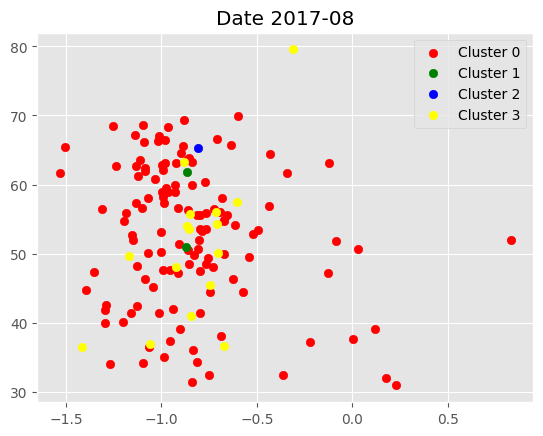

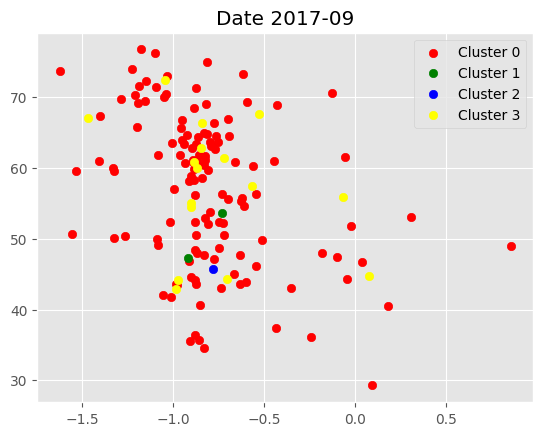

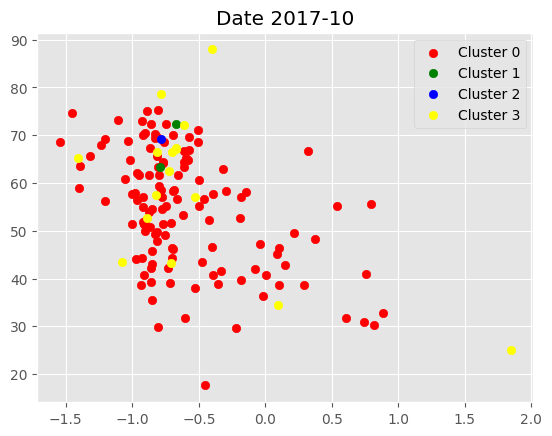

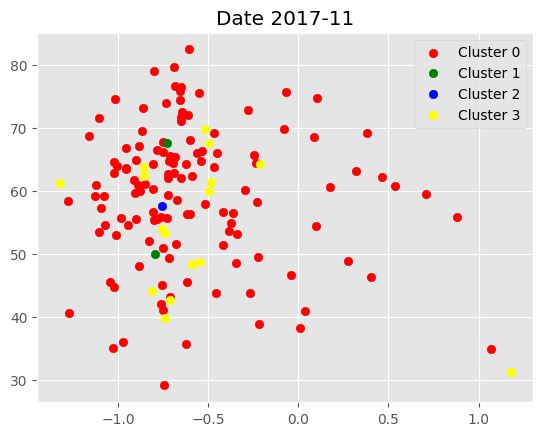

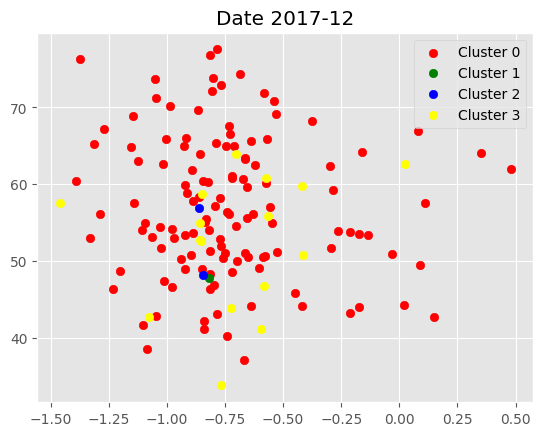

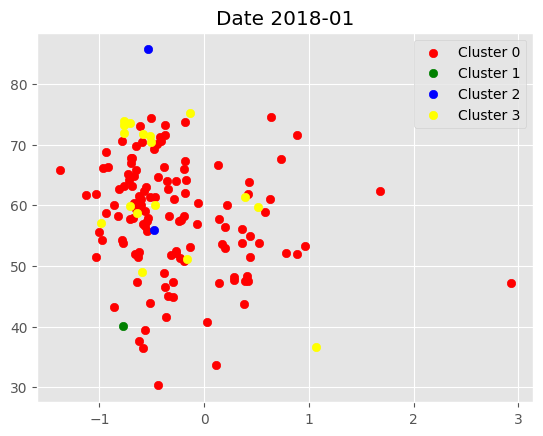

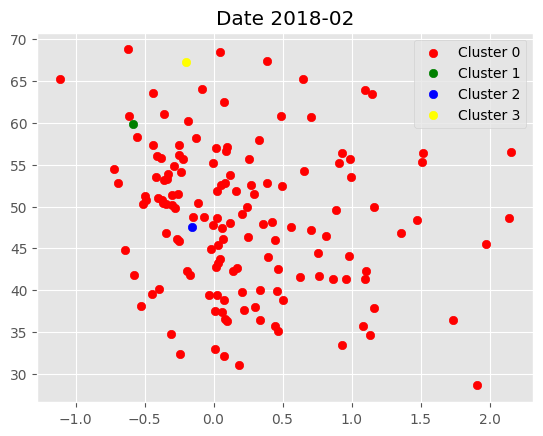

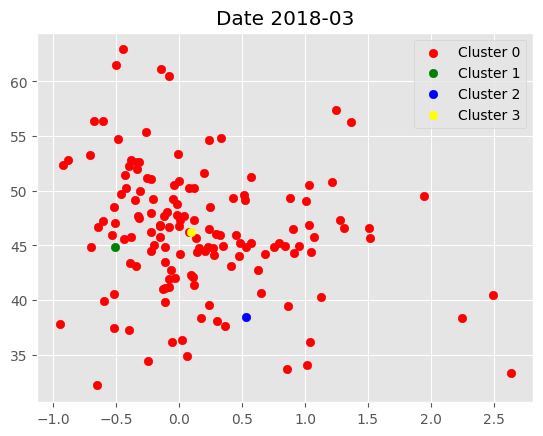

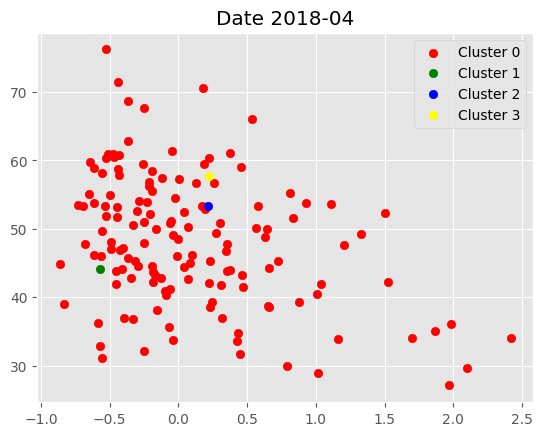

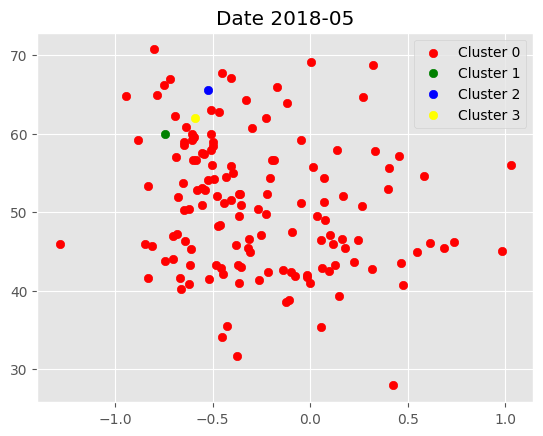

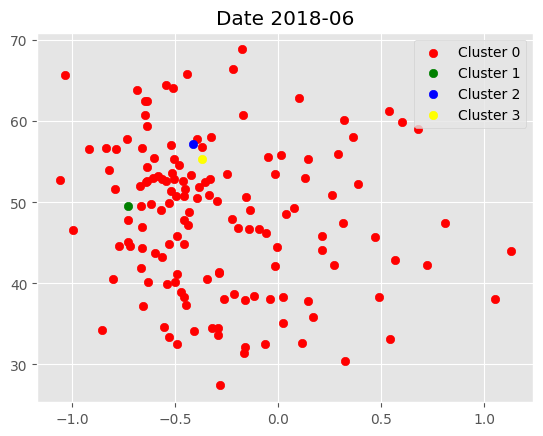

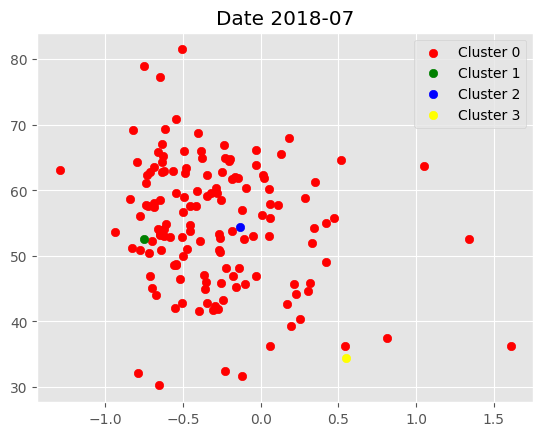

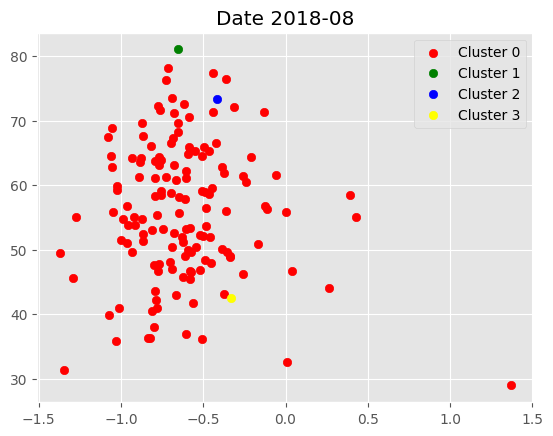

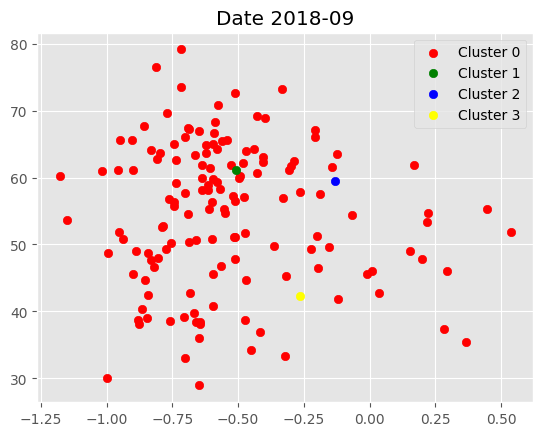

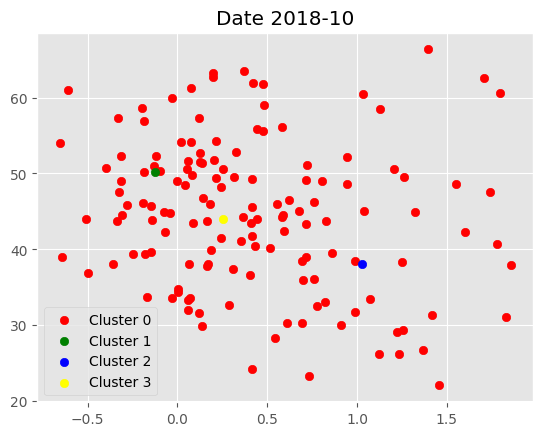

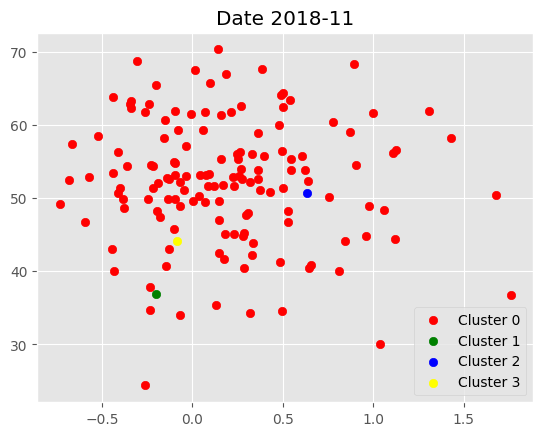

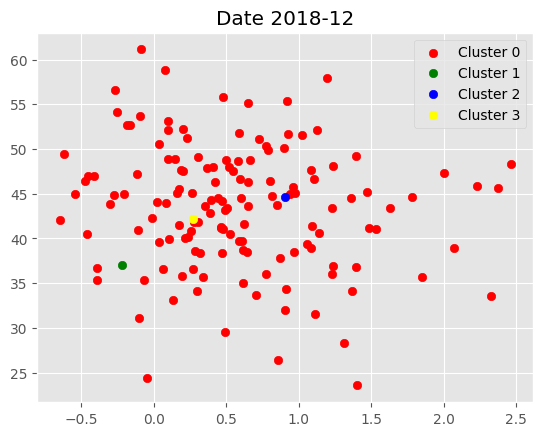

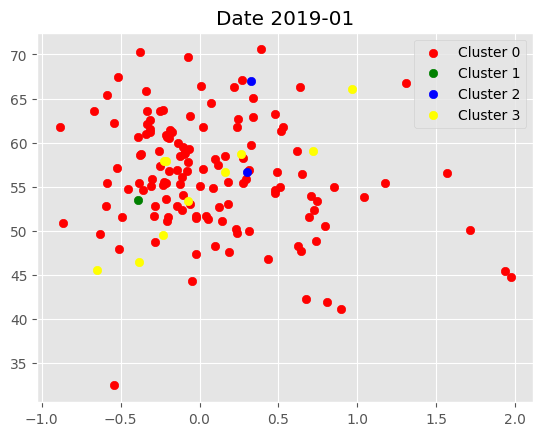

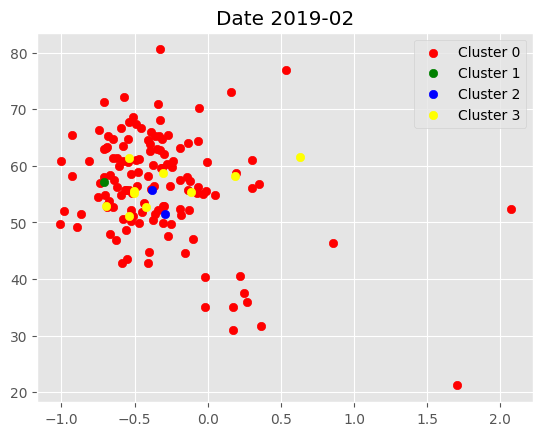

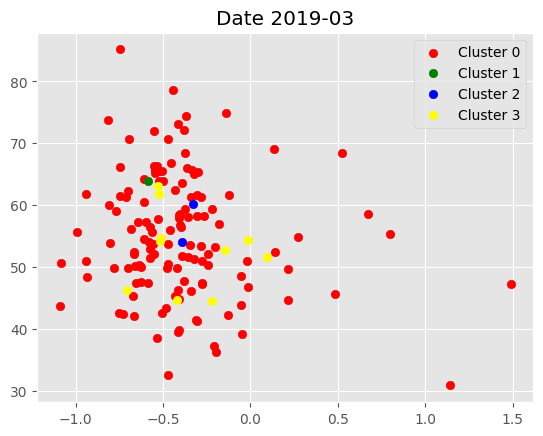

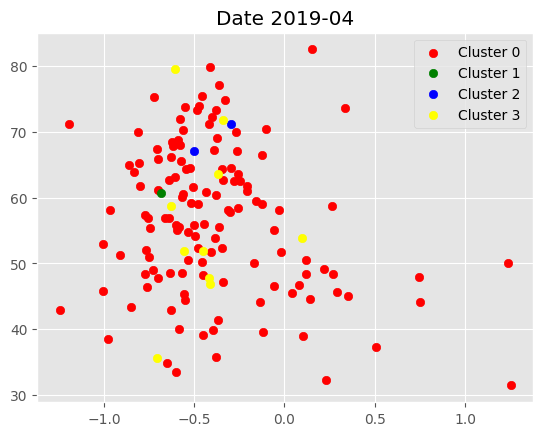

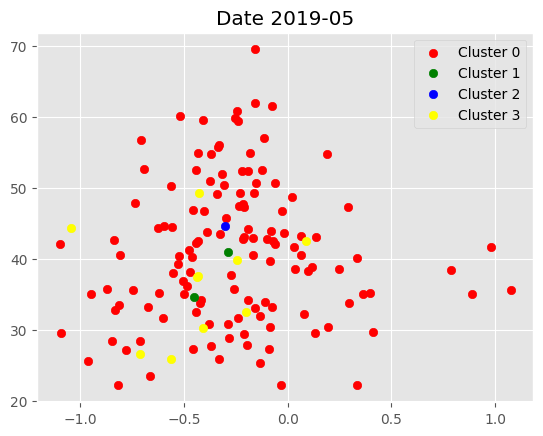

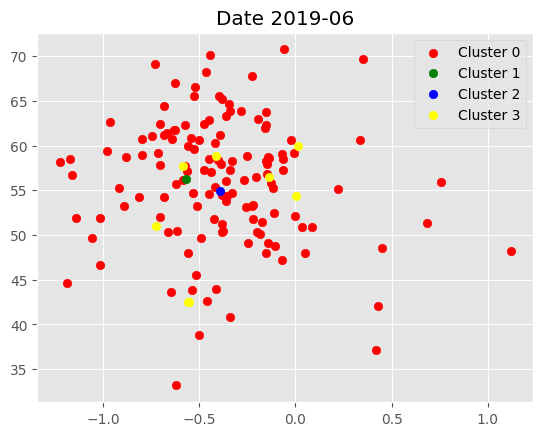

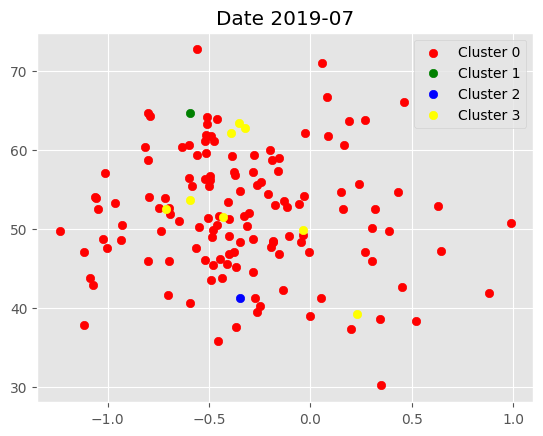

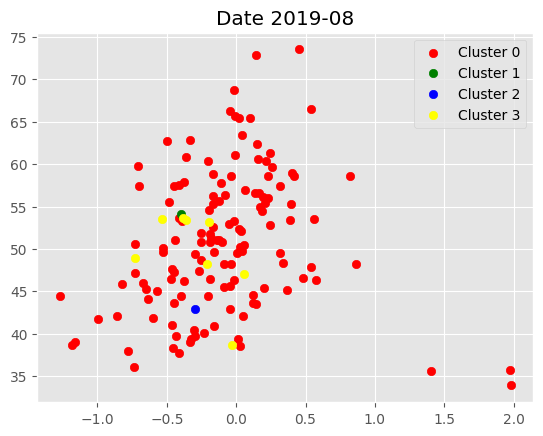

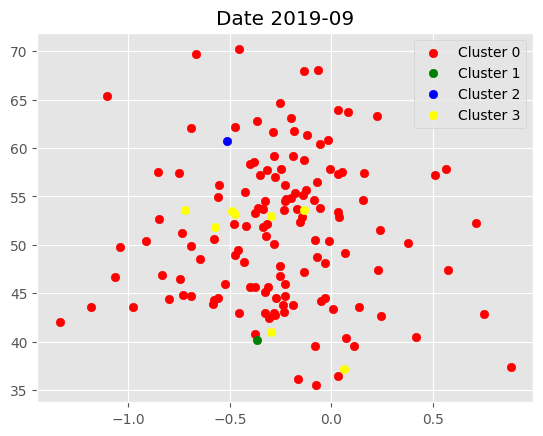

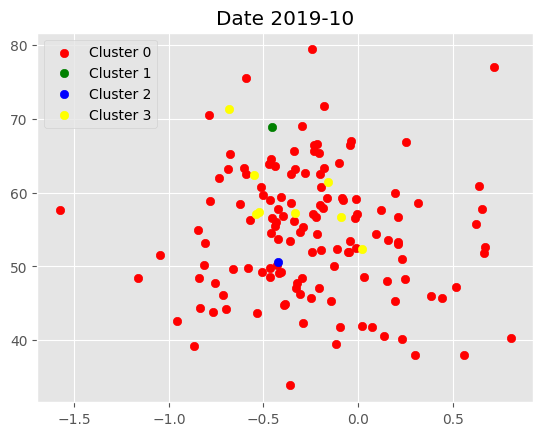

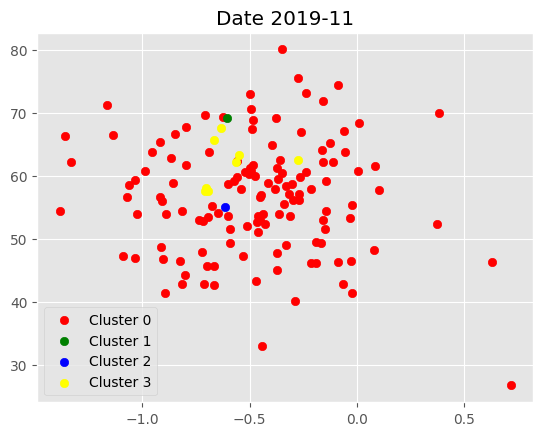

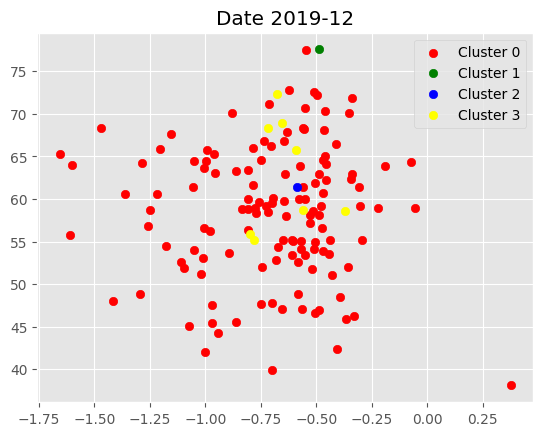

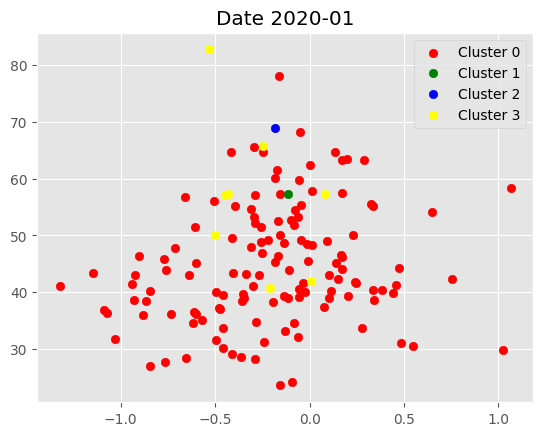

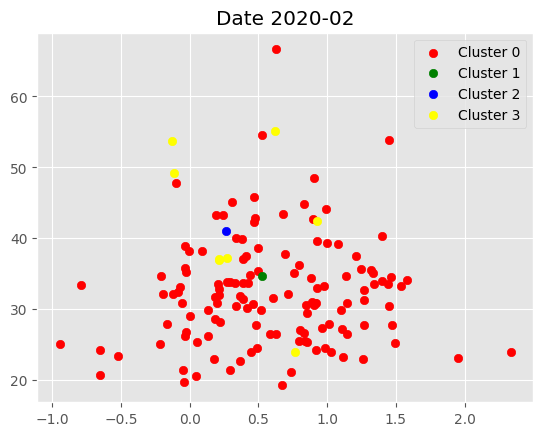

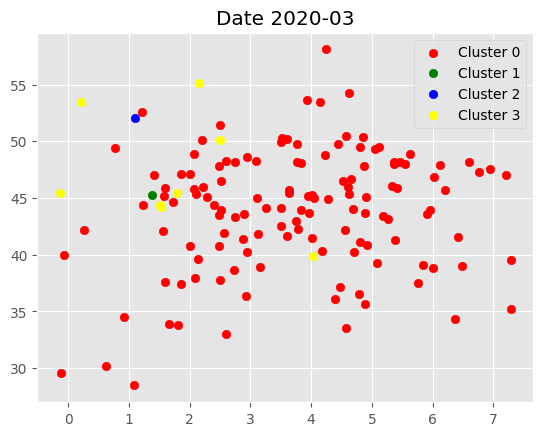

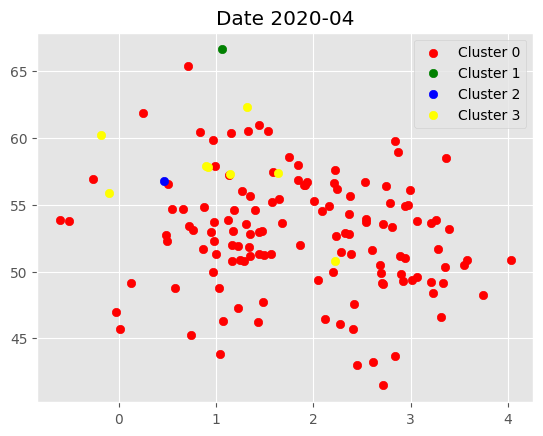

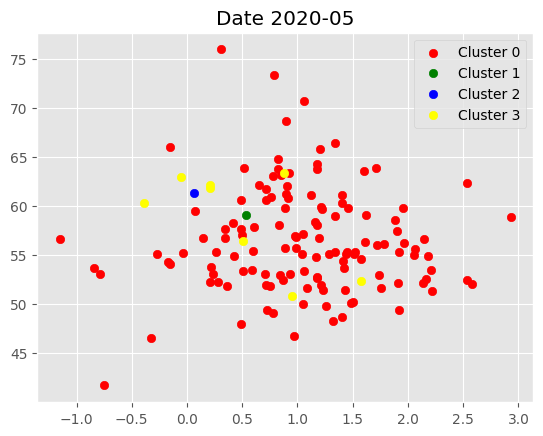

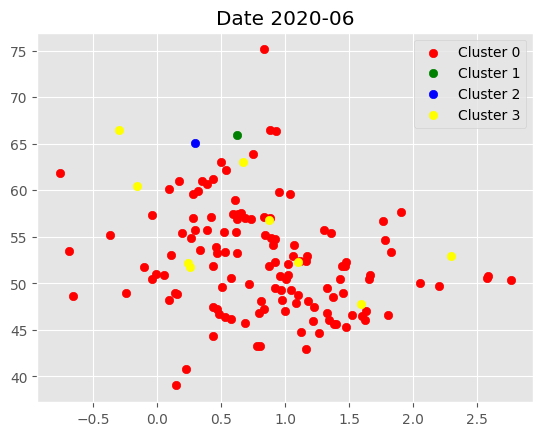

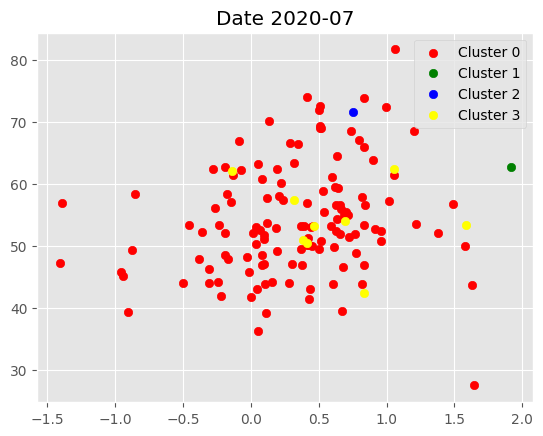

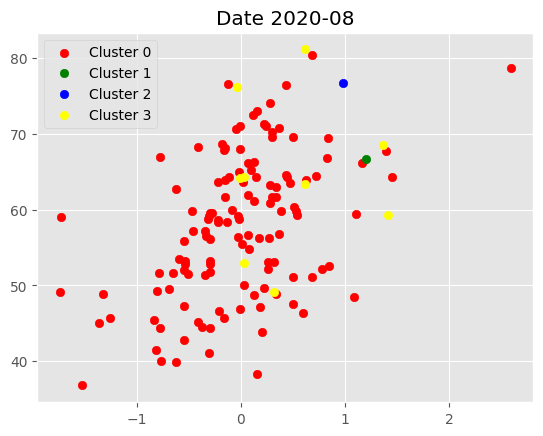

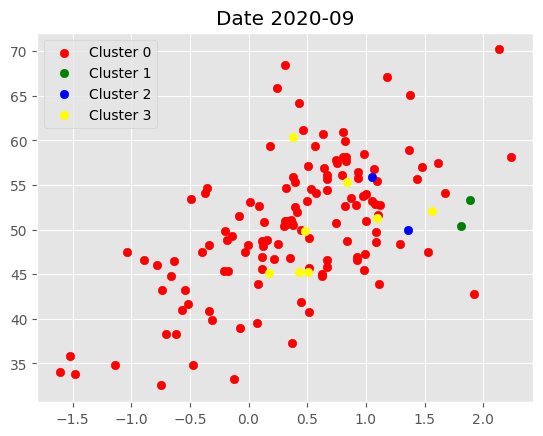

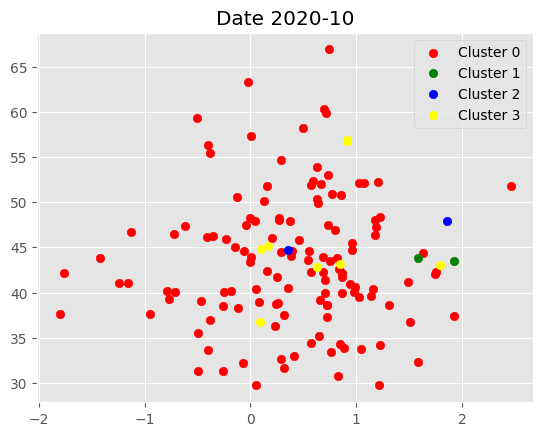

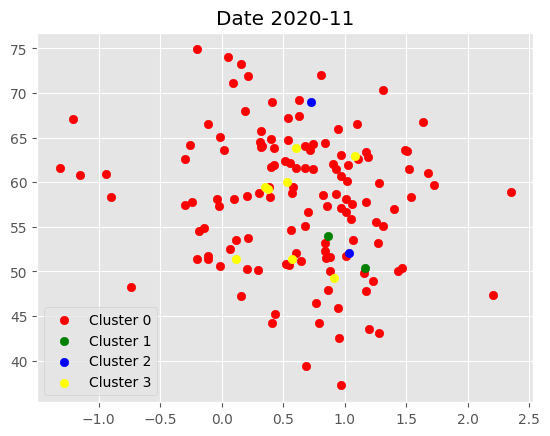

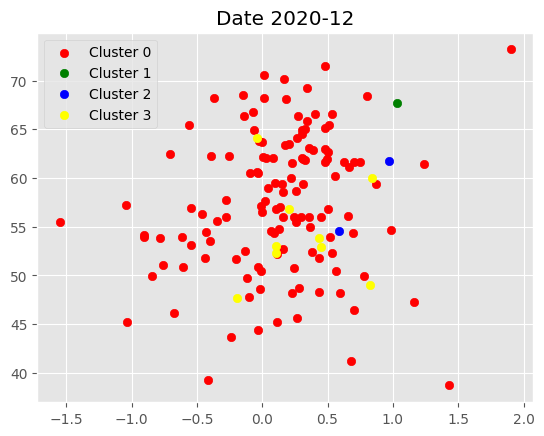

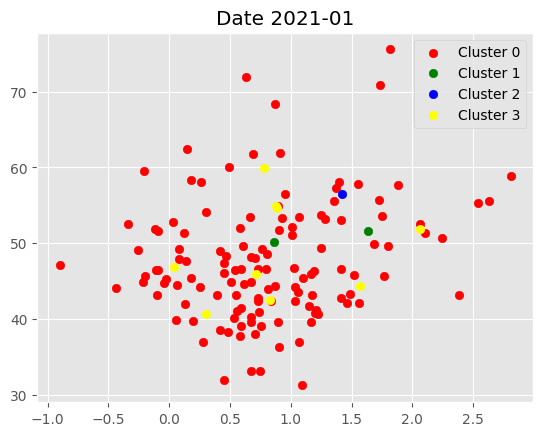

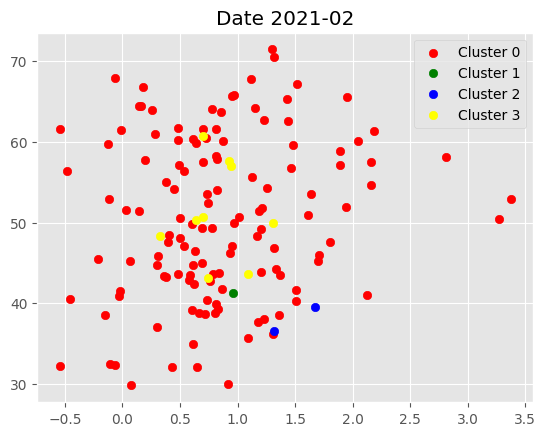

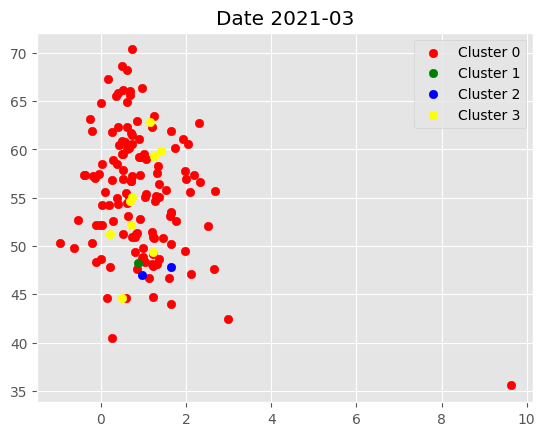

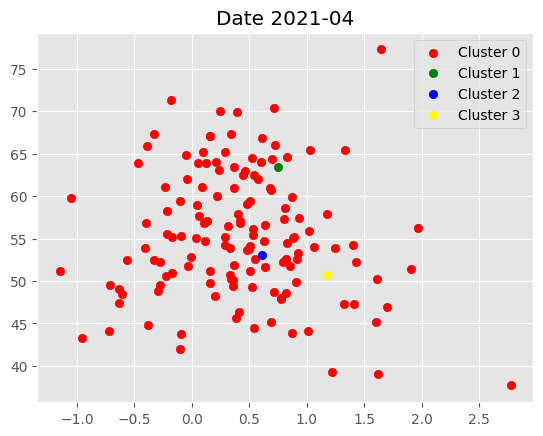

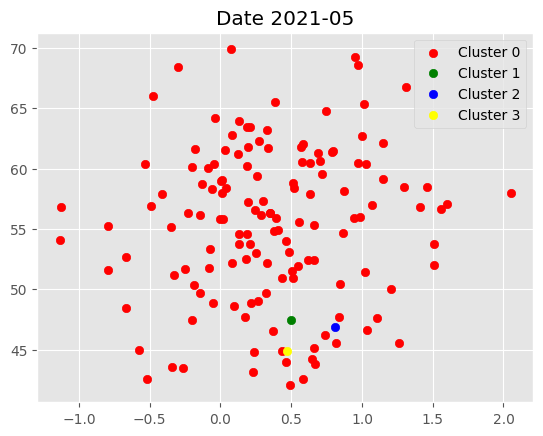

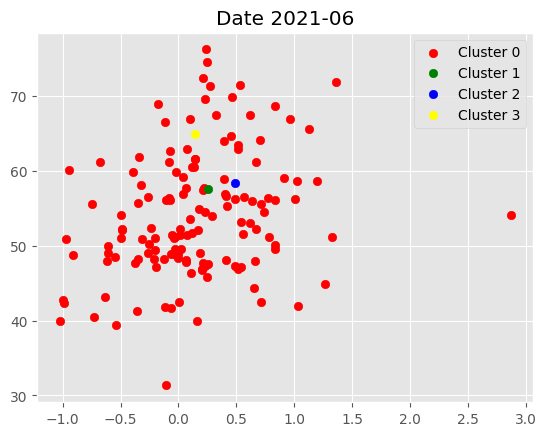

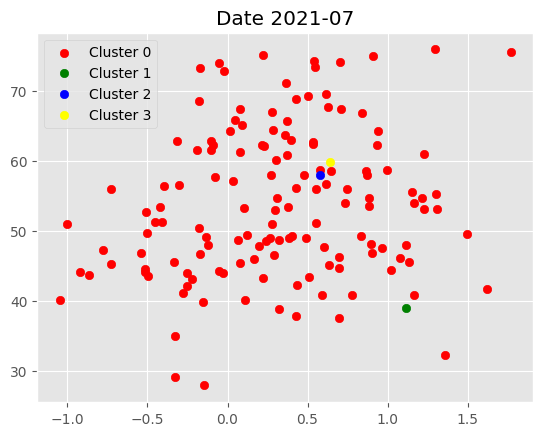

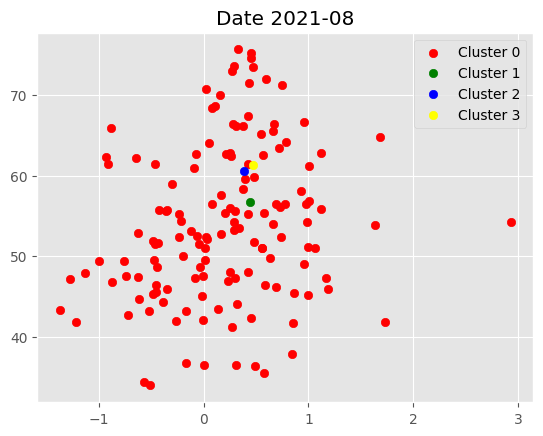

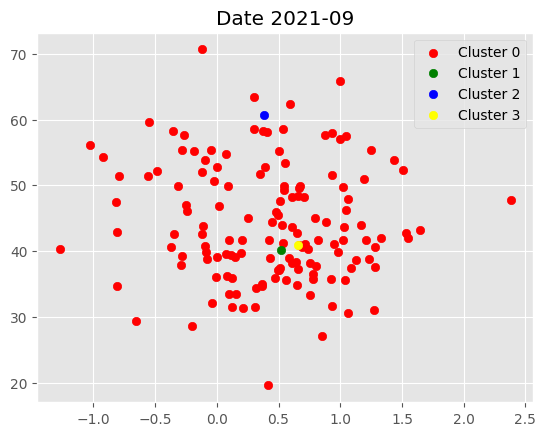

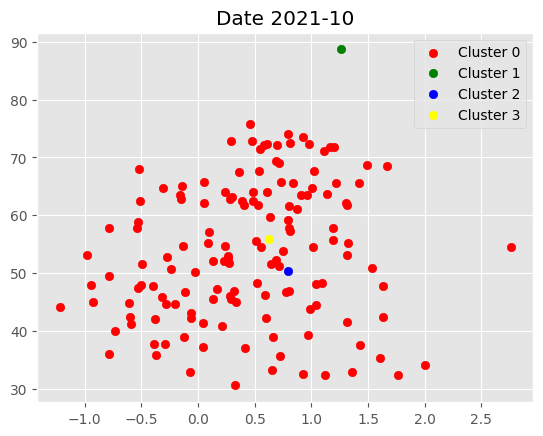

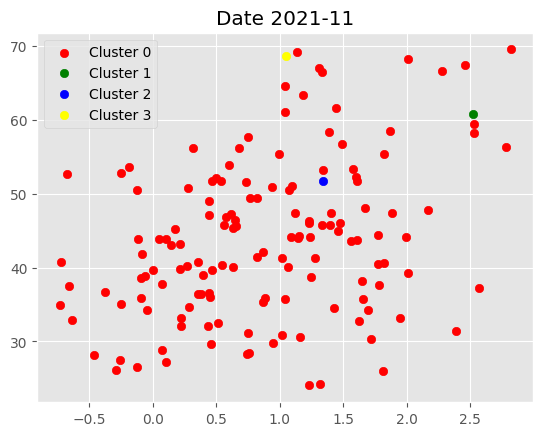

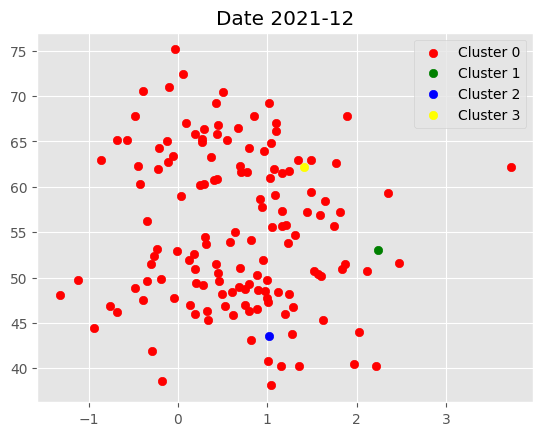

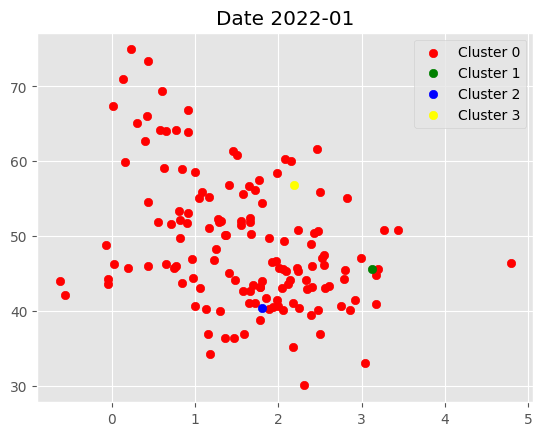

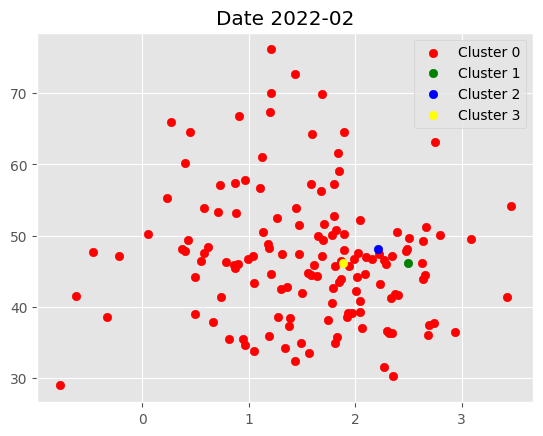

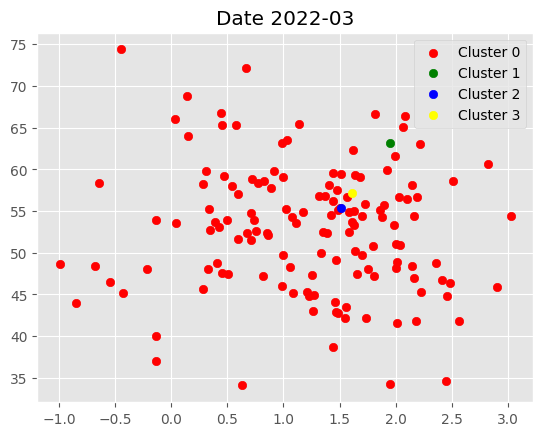

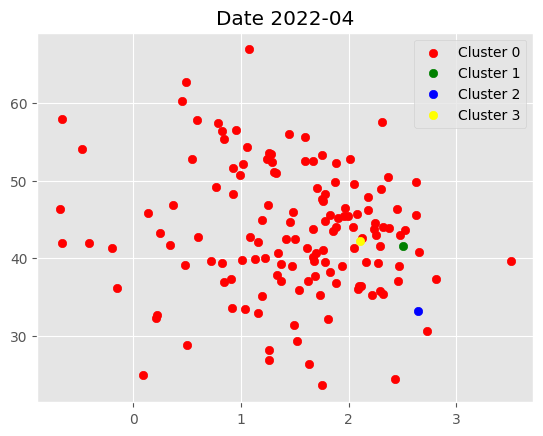

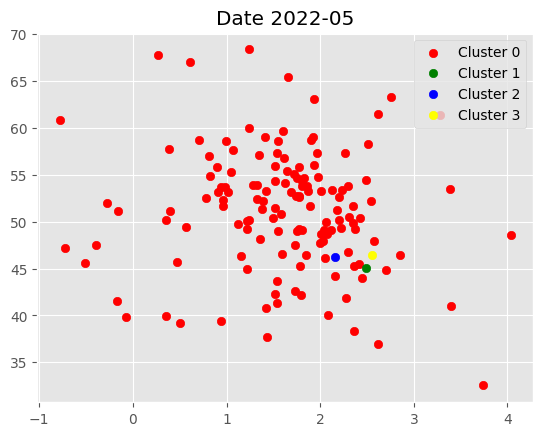

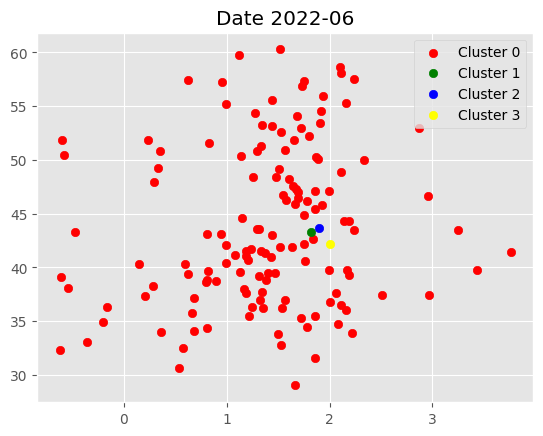

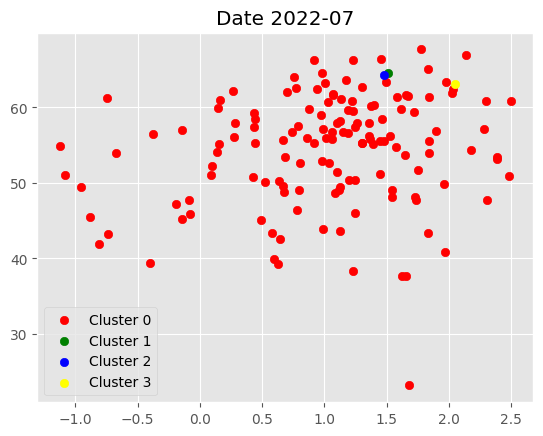

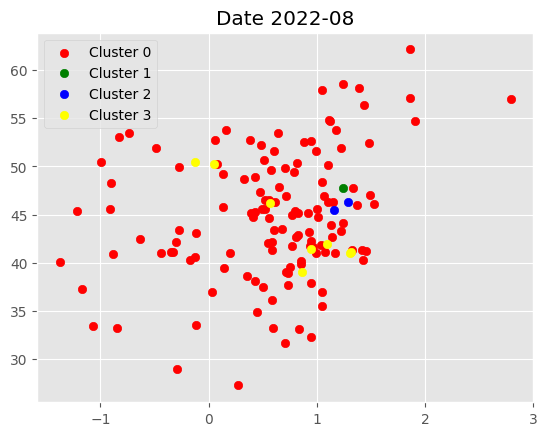

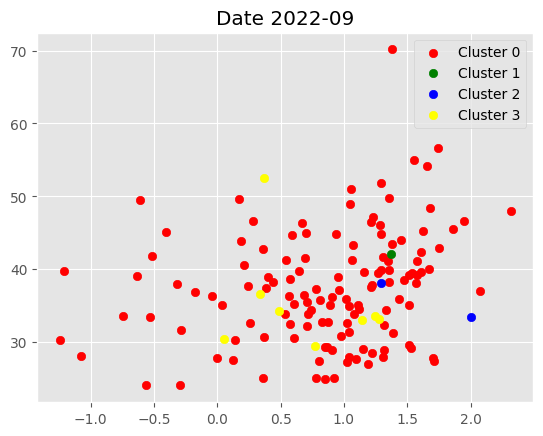

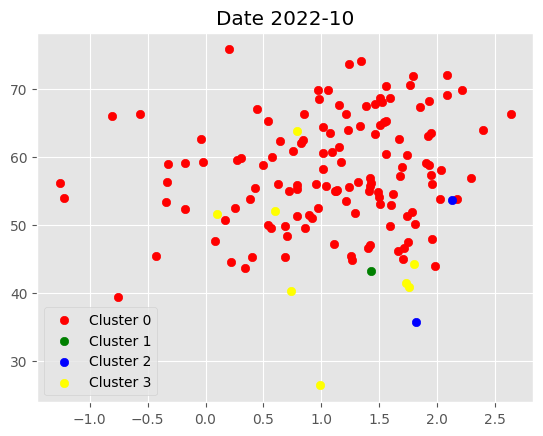

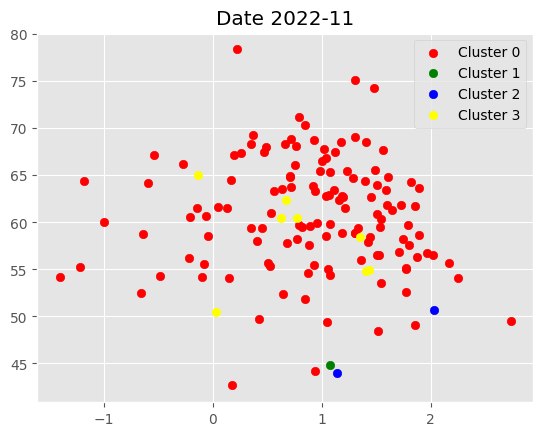

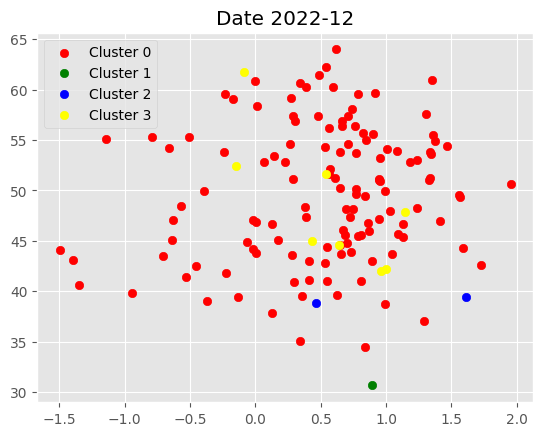

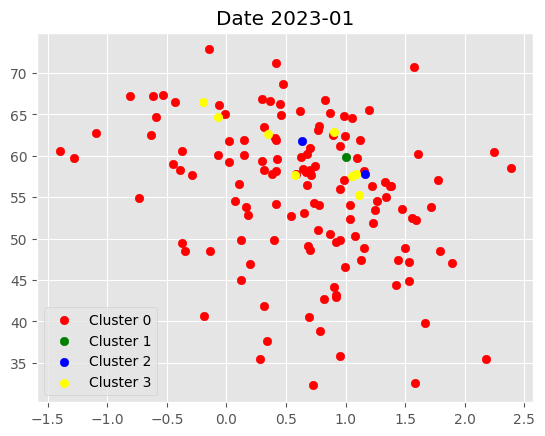

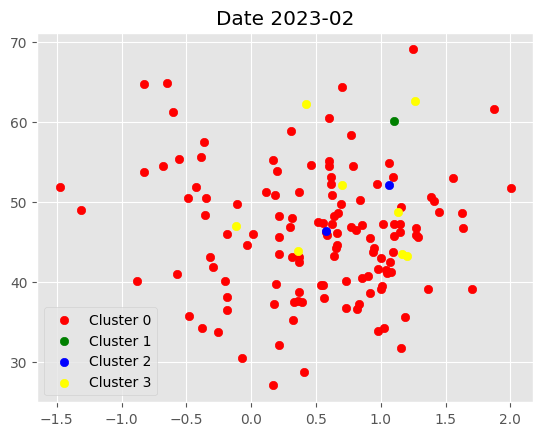

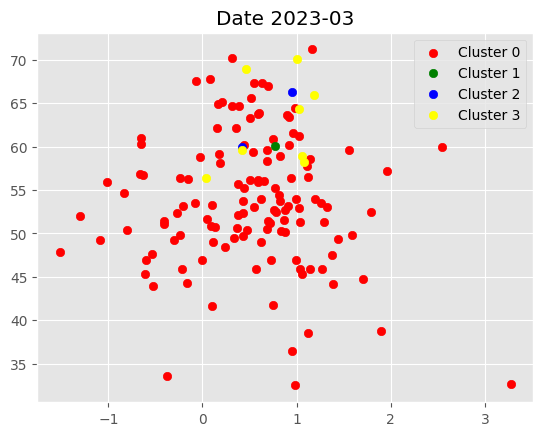

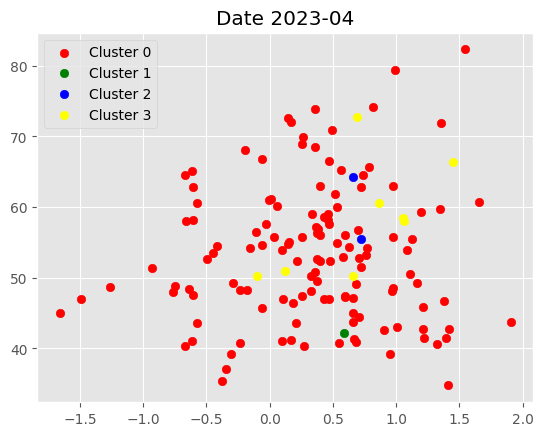

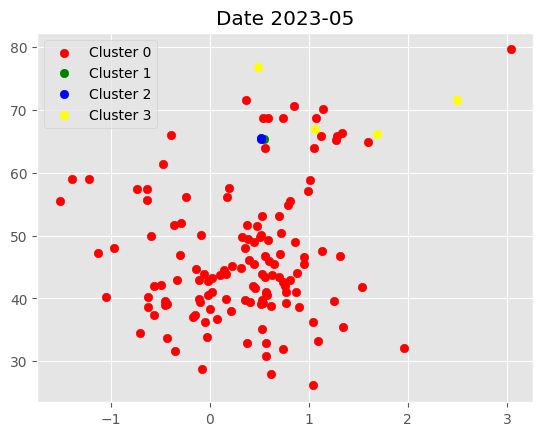

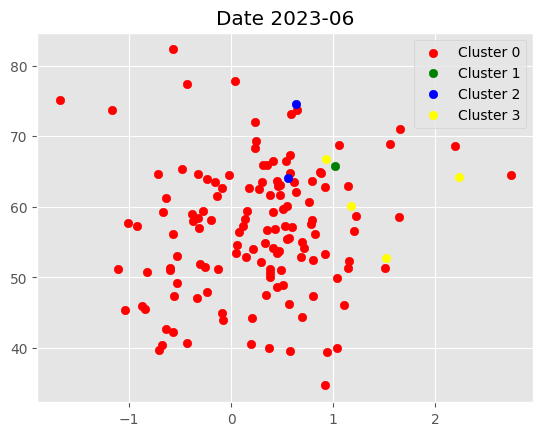

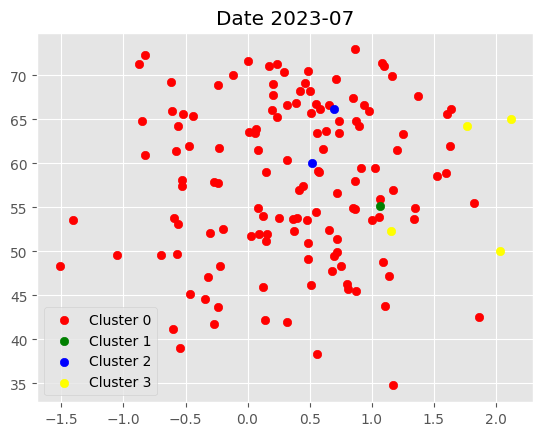

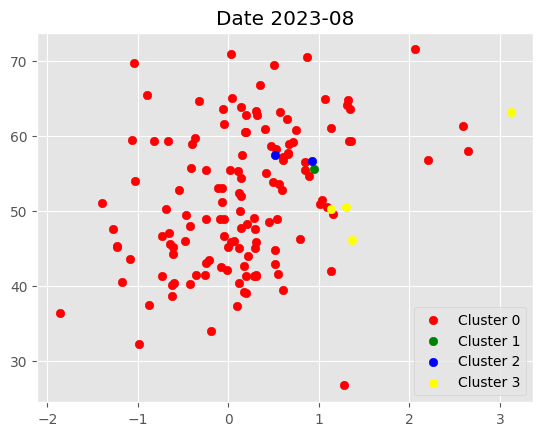

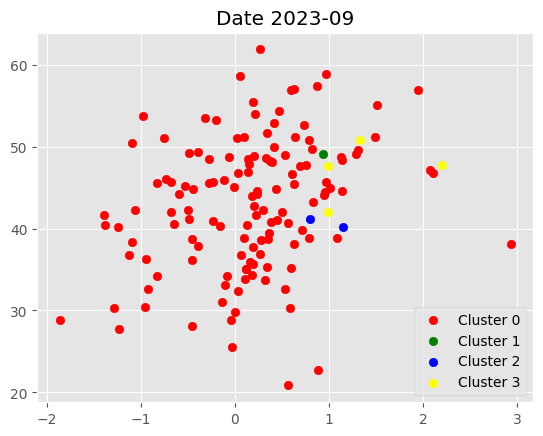

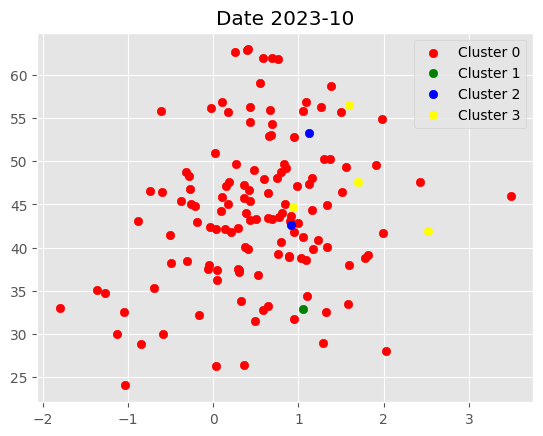

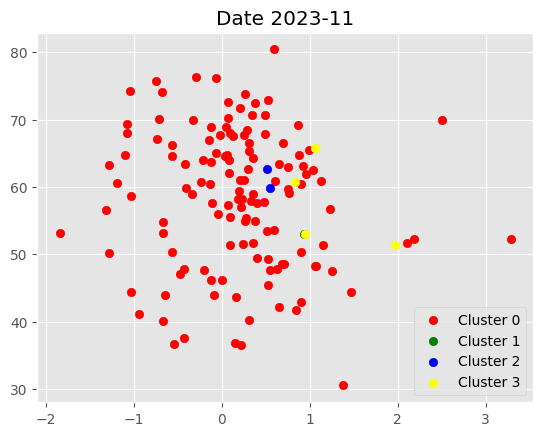

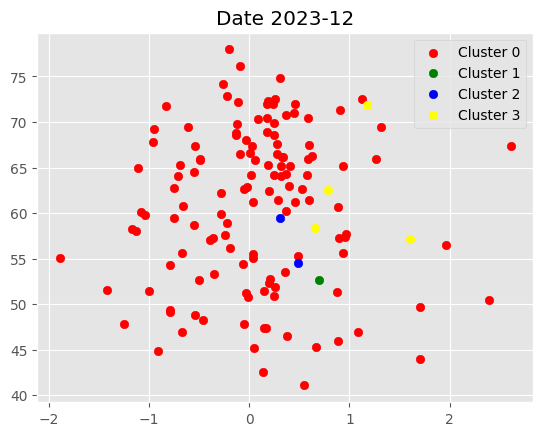

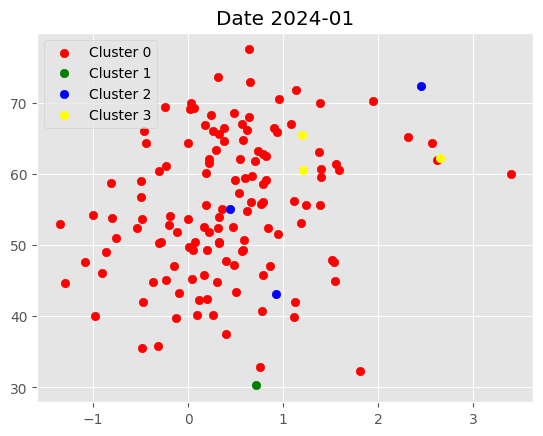

In [45]:
# Plot Clusters
def plot_clusters(df):
    cluster0 = df[df['Cluster']==0]
    cluster1 = df[df['Cluster']==1]
    cluster2 = df[df['Cluster']==2]
    cluster3 = df[df['Cluster']==3]

    plt.scatter(cluster0['ATR'], cluster0['RSI'], color='red', label='Cluster 0')
    plt.scatter(cluster1['ATR'], cluster1['RSI'], color='green', label='Cluster 1')
    plt.scatter(cluster2['ATR'], cluster2['RSI'], color='blue', label='Cluster 2')
    plt.scatter(cluster3['ATR'], cluster3['RSI'], color='yellow', label='Cluster 3')
    
    plt.legend()
    plt.show()
    return 



# def plot_clusters(df):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for i, cluster in df.groupby('Cluster'):
#         cluster.plot.scatter(x='ATR', y='RSI', ax=ax, label=f'Cluster {i}', color=f'C{i}')
        
#     plt.show()
#     plt.legend()
#     return


plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():
    cluster = data.xs(i, level='Date')
    plt.title(f'Date {i.strftime("%Y-%m")}')
    plot_clusters(cluster)
    

    
